## Load Data

In [24]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [53]:
#load data and replace nulls
df = pd.read_csv('Startup Data.csv')
df = df.replace('NaN', np.nan) 

#row 124 and 832 are repeats of the same data point
df.iloc[124] == df.iloc[832]
df = df.drop(832)

In [54]:
#check for unique id columns that can be ignored
print(df['Unnamed: 0'].value_counts().shape == df['Unnamed: 0'].shape)
print(df['id'].value_counts().shape == df['id'].shape)
print(df['name'].value_counts().shape == df['name'].shape)
print(df['object_id'].value_counts().shape == df['object_id'].shape)

#state code is repeated twice with one mismatched state name
print((df['state_code.1'] == df['state_code']).value_counts())

del df['Unnamed: 0']
del df['id']
del df['name']
del df['object_id']
del df['state_code.1']

True
True
True
True
True     921
False      1
dtype: int64


In [55]:
df.head()

,state_code,latitude,longitude,zip_code,city,Unnamed: 6,labels,founded_at,closed_at,first_funding_at,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,CA,42.358880,-71.056820,92101,San Diego,NaN,1,1/1/2007,NaN,4/1/2009,...,1,0,1,0,0,0,0,1.0000,0,acquired
1,CA,37.238916,-121.973718,95032,Los Gatos,NaN,1,1/1/2000,NaN,2/14/2005,...,0,1,0,0,1,1,1,4.7500,1,acquired
2,CA,32.901049,-117.192656,92121,San Diego,San Diego CA 92121,1,3/18/2009,NaN,3/30/2010,...,0,0,0,1,0,0,0,4.0000,1,acquired
3,CA,37.320309,-122.050040,95014,Cupertino,Cupertino CA 95014,1,1/1/2002,NaN,2/17/2005,...,0,0,0,0,1,1,1,3.3333,1,acquired
4,CA,37.779281,-122.419236,94105,San Francisco,San Francisco CA 94105,0,8/1/2010,10/1/2012,8/1/2010,...,0,1,1,0,0,0,0,1.0000,1,closed


## EDA

count    922.000000
mean      38.518566
std        3.743372
min       25.752358
25%       37.388869
50%       37.779281
75%       40.730646
max       59.335232
Name: latitude, dtype: float64


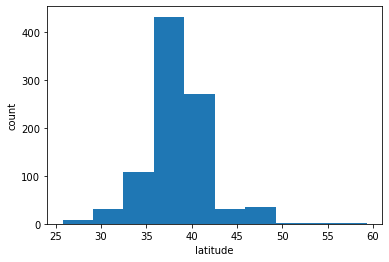

count    922.000000
mean    -103.519249
std       22.398102
min     -122.756956
25%     -122.199823
50%     -118.365504
75%      -77.213612
max       18.057121
Name: longitude, dtype: float64


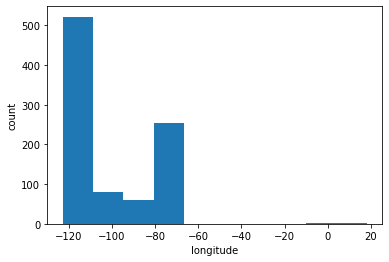

count    922.000000
mean       2.237235
std        2.511337
min       -9.046600
25%        0.574650
50%        1.449350
75%        3.578075
max       21.895900
Name: age_first_funding_year, dtype: float64


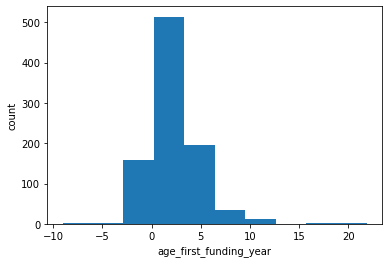

count    922.000000
mean       3.930933
std        2.969478
min       -9.046600
25%        1.669175
50%        3.520550
75%        5.560925
max       21.895900
Name: age_last_funding_year, dtype: float64


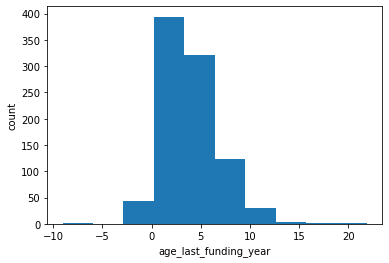

count    770.000000
mean       3.055706
std        2.978976
min      -14.169900
25%        1.000000
50%        2.519150
75%        4.688350
max       24.684900
Name: age_first_milestone_year, dtype: float64


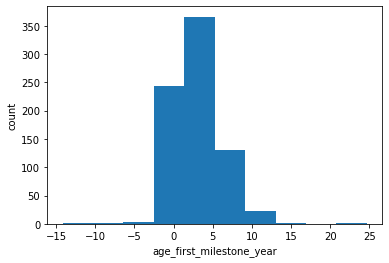

count    770.000000
mean       4.755399
std        3.214081
min       -7.005500
25%        2.397300
50%        4.482200
75%        6.753400
max       24.684900
Name: age_last_milestone_year, dtype: float64


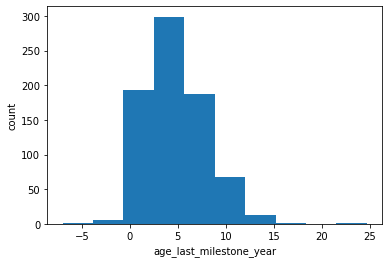

count    922.000000
mean       7.703905
std        7.266762
min        0.000000
25%        3.000000
50%        5.000000
75%       10.000000
max       63.000000
Name: relationships, dtype: float64


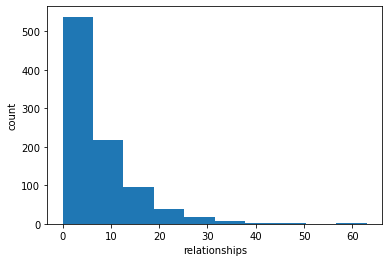

count    922.000000
mean       2.309111
std        1.390562
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       10.000000
Name: funding_rounds, dtype: float64


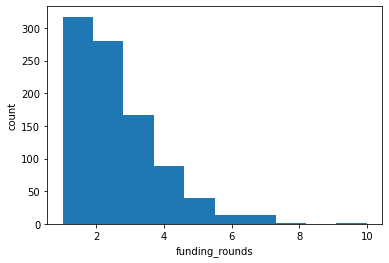

count    9.220000e+02
mean     2.541017e+07
std      1.897371e+08
min      1.100000e+04
25%      2.712500e+06
50%      1.000000e+07
75%      2.465264e+07
max      5.700000e+09
Name: funding_total_usd, dtype: float64


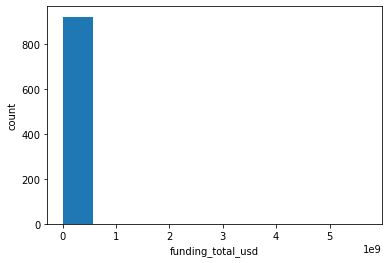

count    922.000000
mean       2.839225
std        1.875518
min        1.000000
25%        1.500000
50%        2.500000
75%        3.800000
max       16.000000
Name: avg_participants, dtype: float64


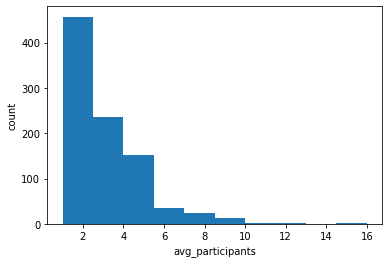

In [56]:
#histograms/bar charts of all features
columns = df.columns
for col in columns:
    if col in ss_ftrs:
        print(df[col].describe())
        df[col].plot.hist()
        plt.xlabel(col)
        plt.ylabel('count')
        plt.show()

In [12]:
#bar plots

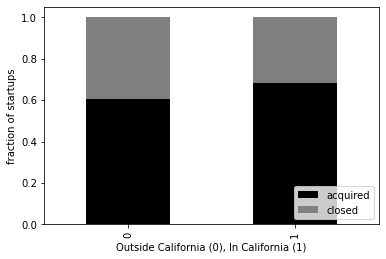

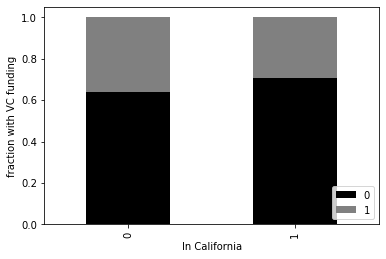

In [13]:
#comparing how well california startups did relative to the rest of the country
count_matrix = df.groupby(['is_CA', 'status']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color = ['k', 'grey'])
plt.xlabel('Outside California (0), In California (1)')
plt.ylabel('fraction of startups')
plt.legend(loc=4)
plt.show()

count_matrix = df.groupby(['is_CA', 'has_VC']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color = ['k', 'grey'])
plt.xlabel('In California')
plt.ylabel('fraction with VC funding')
plt.legend(loc=4)
plt.show()

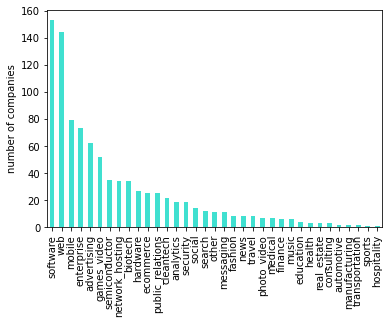

In [14]:
#histogram of the industries
df['category_code'].value_counts().plot.bar(color = 'turquoise')
plt.ylabel('number of companies')
plt.show()

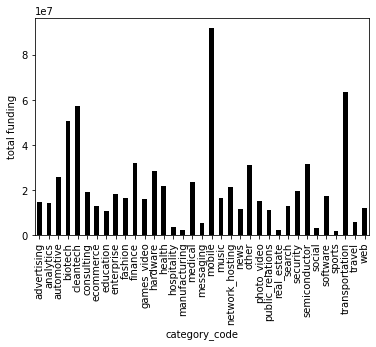

In [15]:
#plot showing industry type against total funding amount in usd
df.groupby('category_code', as_index=True)['funding_total_usd'].mean().plot.bar(color = 'k')
plt.ylabel('total funding')
plt.show()

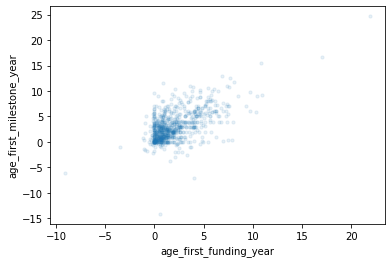

In [16]:
#comparing age of first funding year and age at first milestone shows a high concentration near (0,0)
#this is likely due to many companies who do not recieve any funding
#it is interesting to note the few outliers that were funded much later in their lives
df.plot.scatter('age_first_funding_year', 'age_first_milestone_year', s=10, alpha=.1)
plt.show()

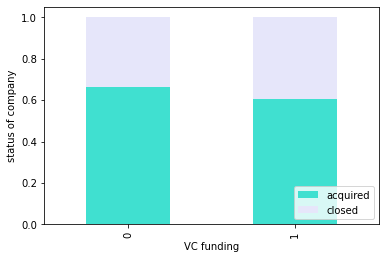

In [17]:
#funding vs status
count_matrix = df.groupby(['has_VC', 'status']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color = ['turquoise', 'lavender'])
plt.ylabel('status of company')
plt.xlabel('VC funding')
plt.legend(loc=4)
plt.show()

In [18]:
df.groupby(['has_VC', 'status']).size().unstack()

status,acquired,closed
has_VC,,
0,414,208
1,182,118


## Split Data

In [64]:
#set X and y matrices
y = df['status']
X = df.loc[:, df.columns != 'status']

In [65]:
#data split
random_state = 7

#separate out training set
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=random_state)

#split out validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X,y,train_size = 0.5,random_state=random_state)

## Missing Data

In [60]:
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('fraction of points with missing values:',frac_missing)

fraction of missing values in features:
Unnamed: 6                  0.533623
closed_at                   0.636659
age_first_milestone_year    0.164859
age_last_milestone_year     0.164859
dtype: float64
data types of the features with missing values:
Unnamed: 6                   object
closed_at                    object
age_first_milestone_year    float64
age_last_milestone_year     float64
dtype: object
fraction of points with missing values: 0.8698481561822126


In [61]:
#categorical missing values new category 'missing'
df["closed_at"] = df["closed_at"].replace(np.nan, "missing")
df["Unnamed: 6"] = df["Unnamed: 6"].replace(np.nan, "missing")

In [62]:
#continuous missing values
print(df[['age_first_milestone_year','age_last_milestone_year']].head())

imputer = SimpleImputer(missing_values= np.nan, strategy='mean')

df[['age_first_milestone_year','age_last_milestone_year']] = imputer.fit_transform(np.array(df[['age_first_milestone_year','age_last_milestone_year']]))

   age_first_milestone_year  age_last_milestone_year
0                    4.6685                   6.7041
1                    7.0055                   7.0055
2                    1.4575                   2.2055
3                    6.0027                   6.0027
4                    0.0384                   0.0384


In [63]:
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('fraction of points with missing values:',frac_missing)

fraction of missing values in features:
Series([], dtype: float64)
data types of the features with missing values:
Series([], dtype: object)
fraction of points with missing values: 0.0


## Preprocessing

In [57]:
#all remaining features split between categorical/continuous/dates to be transformed to continuous
#categorical features split further between ordinal scaler and one hot encoder

cat_ftrs = ['state_code', 'zip_code', 'city','labels', 'is_CA','is_NY','is_MA', 
        'is_TX', 'is_otherstate', 'category_code', 'is_software', 'is_web','is_mobile', 
        'is_enterprise','is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 
        'is_consulting', 'is_othercategory', 'avg_participants', 'has_VC', 'has_angel', 'has_roundA', 
        'has_roundB', 'has_roundC', 'has_roundD','is_top500', 'milestones']

ss_ftrs = ['latitude', 'longitude', 'age_first_funding_year', 'age_last_funding_year', 
            'age_first_milestone_year', 'age_last_milestone_year', 'relationships', 
            'funding_rounds', 'avg_participants', 'funding_total_usd',]

dates = ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at']


In [58]:
#transform dates into continuous variables using epoch time

In [59]:


preprocessor = ColumnTransformer(transformers = 
        [('onehot',  OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_ftrs), 
          ('ss', StandardScaler(), ss_ftrs)])

clf = Pipeline(steps = [('preprocessor', preprocessor)])

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

print(X_train_prep[:5])
#for col in cols:
   # if col in std_ftrs:
       # X_train = scaler.fit_transform(X_train[[col]])


#X_train_ohe = enc.fit_transform(X_train[['state_code']])
#X_train_ohe

[[ 0.          0.          0.         ... -0.9601818   0.07886135
  -0.11928396]
 [ 0.          1.          0.         ... -0.9601818   3.61963765
  -0.11646285]
 [ 0.          1.          0.         ...  2.70681085  1.09051172
   0.09867417]
 [ 0.          0.          0.         ... -0.22678327 -0.93278903
  -0.12035827]
 [ 0.          0.          0.         ... -0.22678327  0.07886135
  -0.11390007]]


## Pipeline

In [66]:
def ML_pipeline(X, y, preprocessor, ML_algo, param_grid):
    test_scores = []
    best_models = []
    
    for i in range(0,10):
        # split data to other/test 80/20, and the use KFold with 4 folds (2 points)
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = 7*i)
        kf = KFold(n_splits=4,shuffle=True,random_state=7*i)
        # preprocess the data (1 point)
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', ML_algo)])
        # loop through the hyperparameter combinations or use GridSearchCV (2 points)
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True)
        # for each combination, calculate the train and validation scores using the evaluation metric
        grid.fit(X_other, y_other)
        # find which hyperparameter combination gives the best validation score (1 point)
        best_combination = grid.best_params_
        # calculate the test score (1 point)
        y_pred = grid.predict(X_test)
        # append the test score and the best model to the lists (1 point)
        test_scores.append(accuracy_score(y_test, y_pred))
        best_models.append(grid.best_estimator_)
    return best_models, test_scores

## Models

In [67]:
ML_algo = SVC()
param_grid = {'regressor__C': np.logspace(-3,4,num=8),'regressor__gamma': np.logspace(-3,4,num=8)}
ML_pipeline(X, y, preprocessor, ML_algo, param_grid)

([Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('onehot',
                                                    OneHotEncoder(handle_unknown='ignore',
                                                                  sparse=False),
                                                    ['state_code', 'zip_code',
                                                     'city', 'labels', 'is_CA',
                                                     'is_NY', 'is_MA', 'is_TX',
                                                     'is_otherstate',
                                                     'category_code',
                                                     'is_software', 'is_web',
                                                     'is_mobile', 'is_enterprise',
                                                     'is_advertising',
                                                     'is_gamesvideo',
                                                  

In [ ]:
random forest
knn class